Do custom install of `sage-importance`

```bash
git clone https://github.com/karelze/sage.git
cd sage
pip install .
```

In [ ]:
import os
import sys
import pickle
from pathlib import Path

from catboost import CatBoostClassifier, Pool

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from torch import nn

sys.path.append("..")
from otc.models.classical_classifier import ClassicalClassifier

from sage import GroupedMarginalImputer, PermutationEstimator

from otc.features.build_features import (
    features_categorical,
    features_classical,
    features_classical_size,
    features_ml,
)

import wandb
from tqdm.auto import tqdm

In [ ]:
SEED = 42

# set globally here
EXCHANGE = "ise"  
STRATEGY = "supervised"  
SUBSET = "test"  

# Change depending on model!
FEATURES = features_ml

In [ ]:
# set project name. Required to access files and artefacts
os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

## Sage Values🌵

In [ ]:
def get_feature_groups(feature_names, feature_str):

    fg_classical = {
        'chg_all_lead (grouped)': ['price_all_lead', 'chg_all_lead'],
        'chg_all_lag (grouped)': ['price_all_lag', 'chg_ex_lag'],
        'chg_ex_lead (grouped)': ['price_ex_lead', 'chg_ex_lead', 'chg_all_lag'],
        'chg_ex_lag (grouped)': ['price_ex_lag'],
        'quote_best (grouped)': ['BEST_ASK', 'BEST_BID', 'prox_best'],
        'quote_ex (grouped)': ['bid_ex', 'ask_ex','prox_ex' ],
        'TRADE_PRICE': ['TRADE_PRICE'],
        }
    
    fg_size = {'size_ex (grouped)': [ 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',  'rel_ask_size_ex', 'bid_size_ex', 'ask_size_ex','depth_ex'], 'TRADE_SIZE': ['TRADE_SIZE']}
    
    fg_ml = {
        "STRK_PRC": ["STRK_PRC"],
        "ttm": ["ttm"],
        "option_type": ["option_type"],
        "root":["root"],
        "myn":["myn"],
        "day_vol":["day_vol"], 
        "issue_type":["issue_type"],
    }
    
    if feature_str == "classical":
        feature_groups = group_names = fg_classical    
    if feature_str == "classical-size":
        feature_groups = group_names = fg_classical | fg_size
    if feature_str == "ml":
        feature_groups = group_names = fg_classical | fg_size | fg_ml      
    

    # Group indices
    groups = []
    for _, group in feature_groups.items():
        ind_list = []
        for feature in group:
            ind_list.append(feature_names.index(feature))
        groups.append(ind_list)

    return groups, group_names


In [ ]:
# load unscaled data for classical classifier
run = wandb.init(project="thesis", entity="fbv")

dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_none:latest"

artifact = run.use_artifact(dataset)
data_dir = artifact.download()

data = pd.read_parquet(Path(data_dir, "test_set.parquet"), engine="fastparquet", columns=[*features_classical_size, "buy_sell"])

y_test = data["buy_sell"]
X_test = data.drop(columns="buy_sell")

feature_names = X_test.columns

### Classical Classifier🏦

In [ ]:
sample_size = 1024 # 4x the recommended default

idx = np.random.choice(y_test.index, size=sample_size, replace=False)

X_importance = X_test.loc[idx]
y_importance = y_test.loc[idx]

In [ ]:
# compare benchmarks
configs = [
    [("quote", "best"), ("quote", "ex")],
    [("trade_size", "ex"), ("quote", "best"),  ("quote", "ex"), ("depth", "best"), ("depth", "ex"), ("rev_tick", "all")]  
]

results = []
for config in configs:
    
    groups, group_names = get_feature_groups(X_importance.columns.tolist(), "classical-size")
    
    clf = ClassicalClassifier(layers=config, random_state=SEED, strategy="random")
    # only set headers etc, no leakage
    clf.fit(X=X_test.head(5), y=y_test.head(5))

    # apply group based imputation + estimate importances in terms of zero-one loss
    imputer = GroupedMarginalImputer(clf, X_importance.values, groups)
    estimator = PermutationEstimator(imputer, "zero one")
    
    # calculate values over entire test set
    sage_values = estimator(X_test.values, y_test.values)
    
    # save sage values + std deviation to data frame
    result = pd.DataFrame(index=group_names, data={"values": sage_values.values, "std": sage_values.std})
    results.append(result)

In [ ]:
# generate names for df
names = []

# generate human readable names like quote(best)->quote(ex)
for r in tqdm(configs):
    name = "->".join("%s(%s)" % tup for tup in r)
    names.append(name)

results_df = pd.concat(results, axis=1, keys=names)

# flatten column names (required to save to parquet)
results_df.columns = [' '.join(col).strip() for col in results_df.columns.values]

In [ ]:
results_df

In [ ]:
KEY = f"{EXCHANGE}_{STRATEGY}_{SUBSET}_classical_feature_importance"

URI_FI_CLASSICAL = f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}.parquet"

results_df.to_parquet(URI_FI_CLASSICAL)

result_set = wandb.Artifact(name=KEY, type="results")
result_set.add_reference(URI_FI_CLASSICAL, name="results")

### Gradient Boosting 🐈

In [ ]:
FEATURE_MAP = {
    "classical": features_classical,
    "classical-size": features_classical_size,
    "ml": features_ml,
}

run = wandb.init(project="thesis", entity="fbv")

# load processed data for gradient-boosting
dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_log_standardized_clipped:latest"

artifact = run.use_artifact(dataset)
data_dir = artifact.download()

data = pd.read_parquet(Path(data_dir, "test_set.parquet"), engine="fastparquet", columns=[*features_ml, "buy_sell"])

y_test = data["buy_sell"]
X_test = data.drop(columns="buy_sell")

feature_names = X_test.columns

In [ ]:
sample_size = 256

idx = np.random.choice(y_test.index, size=sample_size, replace=False)

X_importance = X_test.loc[idx]
y_importance = y_test.loc[idx]

In [ ]:
configs = [("classical", "1gzk7msy_CatBoostClassifier_default.cbm:latest"),
    ("classical-size", "3vntumoi_CatBoostClassifier_default.cbm:latest"),
    ("ml", "2t5zo50f_CatBoostClassifier_default.cbm:latest")]

results = []

for feature_str, model in configs:
    
    # get feature names and slice to subset
    fs = FEATURE_MAP.get(feature_str)
    X_importance_fs = X_importance.loc[:, fs]
    X_importance_cols = X_importance_fs.columns.tolist()
    
    # calculate cat indices
    if feature_str == "ml":
        cat_features = [t[0] for t in features_categorical]
        cat_idx = [X_importance_cols.index(f) for f in cat_features]
    
    # get groups
    groups, group_names = get_feature_groups(X_importance_cols, feature_str)
    
    #  load model by identifier from wandb
    model_name = model.split("/")[-1].split(":")[0]
    
    artifact = run.use_artifact(model)
    model_dir = artifact.download()
    clf = CatBoostClassifier()
    clf.load_model(fname=Path(model_dir, model_name))

    # use callable instead of default catboost as it doesn't work with categoricals otherwise
    def call_catboost(X):
        if feature_str == "ml":       
            # convert categorical to int
            X = pd.DataFrame(X, columns=X_importance.columns)
            # Update the selected columns in the original DataFrame
            X[cat_features] = X.iloc[:, cat_idx].astype(int)
            # pass cat indices
            return clf.predict_proba(Pool(X, cat_features=cat_idx))
        else:
            return clf.predict_proba(X)
    
    # apply group based imputation + estimate importances in terms of zero-one loss
    imputer = GroupedMarginalImputer(call_catboost, X_importance_fs, groups)
    estimator = PermutationEstimator(imputer, "zero one")
    
    # calculate values over entire test set
    sage_values = estimator(X_test.loc[:,fs].values, y_test.values)
    
    # save sage values + std deviation to data frame
    result = pd.DataFrame(index=group_names, data={"values": sage_values.values, "std": sage_values.std})
    results.append(result)

In [ ]:
# list to data frame + set human readable names
names = [f"gbm({feature_str[0]})" for feature_str in configs]
results_df = pd.concat(results, axis=1, keys=names)
results_df.columns = [' '.join(col).strip() for col in results_df.columns.values]

# save to google clound and save identiifer
KEY = f"{EXCHANGE}_{STRATEGY}_{SUBSET}_gbm_feature_importance"

URI_FI_GBM = f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}.parquet"

results_df.to_parquet(URI_FI_GBM)

result_set = wandb.Artifact(name=KEY, type="results")
result_set.add_reference(URI_FI_GBM, name="results")

### Transformer Classifier 🤖

In [ ]:
configs = [
    ("classical", "3jpe46s1_TransformerClassifier_default.pkl:latest"),
    ("classical-size", "1qx3ul4j_TransformerClassifier_default.pkl:latest"), 
    ("ml", "2h81aiow_TransformerClassifier_default.pkl:latest"),
]

results = []

for feature_str, model in configs:
    # load model by identifier from wandb
    model_name = model.split("/")[-1].split(":")[0]

    # get feature names and slice to subset
    fs = FEATURE_MAP.get(feature_str)
    X_importance_fs = X_importance.loc[:, fs]
    X_importance_cols = X_importance_fs.columns.tolist()
    
    # calculate cat indices
    if feature_str == "ml":
        cat_features = [t[0] for t in features_categorical]
        cat_idx = [X_importance_cols.index(f) for f in cat_features]
    
    # get groups
    groups, group_names = get_feature_groups(X_importance_cols, feature_str)
    
    model_name = model.split("/")[-1].split(":")[0]

    artifact = run.use_artifact(model)
    model_dir = artifact.download()

    with open(Path(model_dir, model_name), 'rb') as f:
        clf = pickle.load(f)
    
    # apply group based imputation + estimate importances in terms of zero-one loss
    imputer = GroupedMarginalImputer(clf, X_importance_fs, groups)
    estimator = PermutationEstimator(imputer, "zero one")
    
    # calculate values over entire test set
    sage_values = estimator(X_test.loc[:,fs].values, y_test.values)
    
    # save sage values + std deviation to data frame
    result = pd.DataFrame(index=group_names, data={"values": sage_values.values, "std": sage_values.std})
    results.append(result)

In [ ]:
# list to data frame + set human readable names
names = [f"fttransformer({feature_str[0]})" for feature_str in configs]
results_df = pd.concat(results, axis=1, keys=names)
results_df.columns = [' '.join(col).strip() for col in results_df.columns.values]

# save to google clound and save identiifer
KEY = f"{EXCHANGE}_{STRATEGY}_{SUBSET}_fttransformer_feature_importance"

URI_FI_FTTRANSFORMER = f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}.parquet"

results_df.to_parquet(URI_FI_FTTRANSFORMER)

result_set = wandb.Artifact(name=KEY, type="results")
result_set.add_reference(URI_FI_FTTRANSFORMER, name="results")
run.log_artifact(result_set)

wandb.finish()

## Attention Maps for Transformers

We calculate the average attention map from all transformer blocks, as done in the Gorishniy paper (see [here](https://github.com/Yura52/tabular-dl-revisiting-models/issues/2)). This is different from the Borisov paper (see [here](https://github.com/kathrinse/TabSurvey/blob/main/models/basemodel_torch.py)).

In [125]:
class SaveAttentionMaps:
    """
    Hook for attention maps.

    Inspired by:
    https://github.com/Yura52/tabular-dl-revisiting-models/issues/2#issuecomment-1068123629
    """

    def __init__(self, backward=False):
        self.backward = backward
        self.inputs = []
        self.outputs = []

    def __call__(self, _, inputs, output):
        # module, input, output (tensor, dict(attention_probs, attention_logits))
        # FIXME: layer output instead of attention probs!
        self.inputs.append(inputs)
        self.outputs.append(output[0])

        # if self.backward:
        #     output = output[0]
        #     print(output)
        # else:
        #     # print(output[1]["attention_probs"].requires_grad)
        #     self.tensors.append(output[1]["attention_probs"])

In [126]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from otc.models.activation import ReGLU
from otc.models.fttransformer import (
    CategoricalFeatureTokenizer,
    CLSToken,
    FeatureTokenizer,
    FTTransformer,
    MultiheadAttention,
    NumericalFeatureTokenizer,
    Transformer,
)

num_features_cont = 5
num_features_cat = 1
cat_cardinalities = [2]
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_cat = torch.randint(0, 1, (batch_size, num_features_cat)).to(device)
x_cont = torch.randn(batch_size, num_features_cont).float().to(device)
expected_outputs = torch.randint(0, 1, (batch_size, 1)).float().to(device)

x_cont.requires_grad_(True)
expected_outputs.requires_grad_(True)

params_feature_tokenizer = {
    "num_continous": num_features_cont,
    "cat_cardinalities": cat_cardinalities,
    "d_token": 96,
}
feature_tokenizer = FeatureTokenizer(**params_feature_tokenizer)
params_transformer = {
    "d_token": 96,
    "n_blocks": 3,
    "attention_n_heads": 8,
    "attention_initialization": "kaiming",
    "ffn_activation": ReGLU,
    "attention_normalization": nn.LayerNorm,
    "ffn_normalization": nn.LayerNorm,
    "ffn_dropout": 0.1,
    "ffn_d_hidden": 96 * 2,
    "attention_dropout": 0.1,
    "residual_dropout": 0.1,
    "prenormalization": True,
    "first_prenormalization": False,
    "last_layer_query_idx": None,
    "n_tokens": None,
    "kv_compression_ratio": None,
    "kv_compression_sharing": None,
    "head_activation": nn.ReLU,
    "head_normalization": nn.LayerNorm,
    "d_out": 1,
}

transformer = Transformer(**params_transformer)

model = FTTransformer(feature_tokenizer, transformer).to(device)

In [127]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# forward pass
criterion = nn.BCEWithLogitsLoss()

logits = model(x_cat, x_cont)

# zero gradients
model.zero_grad()

loss = criterion(logits, expected_outputs)

loss.backward()

In [128]:
# Prepare data and model.
n_objects = len(x_cat)  # 12
n_features = num_features_cont + num_features_cat

# The following hook will save all attention maps from all attention modules.
forward_hook = SaveAttentionMaps()
backward_hook = SaveAttentionMaps(backward=True)

for block in model.transformer.blocks:

    # forward: module, input, output
    block.attention.register_forward_hook(forward_hook)
    # backward: module, grad_input, grad_output
    block.attention.register_full_backward_hook(backward_hook)

# apply the model to all objects.
out = model(x_cat, x_cont)

# calculate outputs
logits = model(x_cat, x_cont)
# zero gradients
model.zero_grad()
# loss + backward pass
loss = criterion(logits, expected_outputs)
loss.backward()

# model.eval()
# with torch.inference_mode():
#     model(x_cat, x_cont)

# # Collect attention maps
# n_blocks = len(model.transformer.blocks)
# n_heads = model.transformer.blocks[0].attention.n_heads
# n_tokens = n_features + 1
# attention_maps = torch.cat(forward_hook.tensors)
# assert attention_maps.shape == (n_objects * n_blocks * n_heads, n_tokens, n_tokens)

# # Calculate feature importance and ranks.
# average_attention_map = attention_maps.mean(0)
# average_cls_attention_map = average_attention_map[-1]  # consider only the [CLS] token
# feature_importance = average_cls_attention_map[:-1]  # drop the [CLS] token importance
# assert feature_importance.shape == (n_features,)

# feature_importance = feature_importance.detach().cpu().numpy()
# # feature_ranks = scipy.stats.rankdata(-feature_importance)
# # feature_indices_sorted_by_importance = feature_importance.argsort()[::-1]

# print(feature_importance)
# # print(feature_ranks)
# # print(feature_indices_sorted_by_importance)

In [47]:
# https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/lxmert/lxmert/src/ExplanationGenerator.py#L26
# https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb#scrollTo=fWKGyu2YAeSV

# attn_block = model.transformer.blocks[0].attention.get_attn()
# cat + cont + [CLS]
# num_tokens = attn_block.shape[-1]
# residual connection. Repeat along batch dimension
res = torch.eye(n_tokens, n_tokens).to(device)
res = res.unsqueeze(0).expand(batch_size, n_tokens, n_tokens)

# one_hot = expected_outputs.sum()
# one_hot.backward(retain_graph=True)

for i, attn_probs in enumerate(hook.attention_maps):

    # grad = block.attention.get_attn_gradients().detach()
    # cam = block.attention.get_attn().detach()
    # print(attn_probs.requires_grad_(True))
    # grad = grad = torch.autograd.grad(loss, [attn_probs], create_graph=True, allow_unused=True)[0].detach()
    grad = attn_probs
    cam = attn_probs


    # reshape to [batch_size x num_head, num_tokens, num_tokens]
    # cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
    # grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
    
    # dot product
    cam = grad * cam
    
    # reshape to [batch_size, num_head, num_tokens, num_tokens]
    cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
    # clamp negative values, calculate mean over heads
    cam = cam.clamp(min=0).mean(dim=1)
    res = res + torch.bmm(cam, res)

relevancy = res
# disregard the first token, which is the [CLS] token
# relevancy[:,0,0] = 0

# in FT-Transformer token is appended / preprended to the end of the sequence

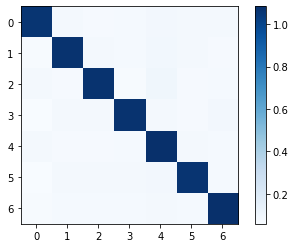

In [50]:
# get first attention map from batch and visualize
test = relevancy[0].detach().cpu().numpy()
plt.imshow(test, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()
